<a href="https://colab.research.google.com/github/amangupta2/ai_weather/blob/main/Comparing_WeatherBench_with_Meteostat_radars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note that pip might complain about some versions but the notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbenchX.git
#!pip install stationbench
!pip install cartopyf
! pip install netCDF4
! pip install meteostat

  Cloning https://github.com/google-research/weatherbenchX.git to /tmp/pip-req-build-8hb3p5y2
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbenchX.git /tmp/pip-req-build-8hb3p5y2
  Resolved https://github.com/google-research/weatherbenchX.git to commit 0fa584bfcdbcb2c33002b23410bb920b97d8ca88
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 56.3 MB/s eta 0:00:00


In [2]:
import apache_beam as beam
import numpy as np
import xarray as xr
import weatherbenchX
from weatherbenchX.data_loaders import xarray_loaders
from weatherbenchX.metrics import deterministic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from weatherbenchX import weighting
from weatherbenchX import binning
from weatherbenchX import time_chunks
from weatherbenchX import beam_pipeline
#import stationbench

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#
from netCDF4 import Dataset

#import numpy as np
from datetime import datetime
#import matplotlib.pyplot as plt
from meteostat import Point, Daily, Monthly, Hourly, Stations
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

In [3]:
from google.colab import auth, drive

# Authenticate user
auth.authenticate_user()
# connect Google Drive
drive.mount('/content/drive')
# load file
f = '/content/drive/MyDrive/ERA5_lsm.nc'
nc = Dataset(f)
lsm = nc.variables['lsm'][0,:,:]

Mounted at /content/drive


In [4]:
# Defining error metric functions

# Compute latitude weighted RMSE wrt ERA5: globally and over India
def RMSE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  rmse_global = np.sqrt(np.mean(np.mean(anom**2,2),1)) #np.sqrt(np.mean(np.mean(anom**2,2)*factor[np.newaxis,:],1)/np.mean(factor))
  rmse_india  = np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2),1)) #np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2)*factor2[np.newaxis,:],1)/np.mean(factor2))

  return rmse_global, rmse_india

# Compute latitude-weighted MAE: globally and over India
def MAE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  mae_global = np.mean(np.mean(np.abs(anom),2),1)
  mae_india  = np.mean(np.mean(np.abs(anom)[:,208:329,272:393],2),1)

  return mae_global, mae_india


# Compute latitude-weighted anomaly correlation coefficient: globally and over India
def ACC(pred, truth, lat):
  ...

In [5]:
# Load radar data

start = datetime(2020,1,1,0,0,0)
end   = datetime(2020,1,2,23,0,0)

# Bhadla solar park
#bhadla = Point(27.5175957,71.9278131)
delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
madras      = Point(13.0, 80.1833)
agartala    = Point(23.8315, 91.2868)
calcutta    = Point(22.5333, 88.3333)
bhopal      = Point(23.2833, 77.35)

delhi_data       = Hourly(delhi,start,end) # daily
#bhuj_data        = Hourly(bhuj,start,end)
madras_data      = Hourly(madras,start,end)
agartala_data    = Hourly(agartala,start,end)
calcutta_data    = Hourly(calcutta,start,end)
bhopal_data      = Hourly(bhopal,start,end)

delhi_data       = delhi_data.fetch()
#bhuj_data        = bhuj_data.fetch()
madras_data      = madras_data.fetch()
agartala_data    = agartala_data.fetch()
calcutta_data    = calcutta_data.fetch()
bhopal_data      = bhopal_data.fetch()

In [7]:
delhi_data['temp'][0::6].shape

(8,)

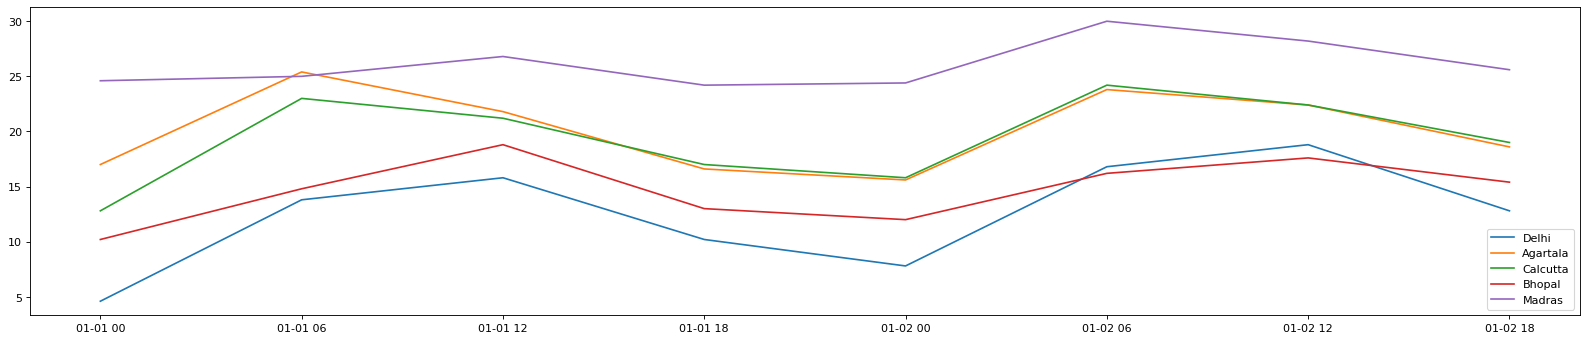

In [6]:
# Bhopal and Agartala have broken data. Use the other three

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(delhi_data['temp'][0::6], color='C0', label='Delhi')
plt.plot(agartala_data['temp'][0::6], color='C1', label='Agartala')
plt.plot(calcutta_data['temp'][0::6], color='C2', label='Calcutta')
plt.plot(bhopal_data['temp'][0::6], color='C3', label='Bhopal')
plt.plot(madras_data['temp'][0::6], color='C4', label='Madras')
plt.legend()

In [9]:
# Loading WeatherBench data
# data guide: https://weatherbench2.readthedocs.io/en/latest/data-guide.html

# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'

#prediction_path_neuralgcm    = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
#prediction_path_sphericalcnn = ''gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr''


In [10]:
# All datasets available at 6-hourly resolution
time1='2020-01-01T00:00:00.000000000'
time2='2020-01-02T18:00:00.000000000' # 02 to 05 for testing


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# forecast is made every 6 hours using initial conditions every 12 hours. so time axis has 2 samples per day, but the prediction_delta has 6 samples per timestamp
data_era5          = ds_era5.sel(time=slice(time1, time2))
data_hres          = ds_hres.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_pangu         = ds_pangu.sel(time=slice(time1, time2))
data_graphcast     = ds_graphcast.sel(time=slice(time1, time2))
data_fuxi          = ds_fuxi.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_panguoper     = ds_panguoper.sel(time=slice(time1, time2))
data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time2))
data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time2))
data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time2))

print('Done')

Done


In [67]:
data_era5_fcst['2m_temperature']

<xarray.DataArray '2m_temperature' (time: 4, prediction_timedelta: 31,
                                    latitude: 721, longitude: 1440)> Size: 515MB
[128741760 values with dtype=float32]
Coordinates:
  * latitude              (latitude) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * longitude             (longitude) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 248B 00:00:0...
  * time                  (time) datetime64[ns] 32B 2020-01-01 ... 2020-01-02...
Attributes:
    long_name:      2 metre temperature
    short_name:     t2m
    standard_name:  unknown
    units:          K

In [78]:
#data_hres
#data_pangu
#data_graphcast
#data_fuxi

p1=0
p2=8 # 8

lat1 = data_era5['latitude'].values
lat2 = data_hres['latitude'].values
lon = data_era5['longitude'].values

#p_era5 = data_era5['level'].values
t_era5 = data_era5['2m_temperature']
u_era5 = data_era5['10m_u_component_of_wind']
v_era5 = data_era5['10m_v_component_of_wind']

#p_hres = data_hres['level'].values
t_hres = data_hres['2m_temperature'].values
u_hres = data_hres['10m_u_component_of_wind'].values
v_hres = data_hres['10m_v_component_of_wind'].values

#p_pangu = data_pangu['level'].values
t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_graphcast = data_graphcast['level'].values
t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_fuxi = data_fuxi['level'].values
t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_panguoper = data_panguoper['level'].values
t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1:p2,:,:].values
u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

# example
#t_fuxi.shape

In [77]:
data_ifshres_fcst['2m_temperature'].shape

(4, 41, 721, 1440)

# Data loading complete. Now compare. First compare radar with ERA5 and HRES analysis. Then, compare forecasts over short lead times.


In [79]:
# interpolating model timeseries to radar locations - linear interpolation from immediate boundaries will suffice for now
from scipy.interpolate import LinearNDInterpolator

#delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
#madras      = Point(13.0, 80.1833)
#agartala    = Point(23.8315, 91.2868)
#calcutta    = Point(22.5333, 88.3333)
#bhopal      = Point(23.2833, 77.35)

# delhi
lat0=28.6439835
lon0=76.9280785

#madras
#lat0=13.
#lon0=80.1833

# calcutta
#lat0=22.5333
#lon0=88.3333

ix1=len(lon[lon<lon0])-1
ix2=len(lon[lon<lon0])

# ERA5, Pangu, and PanguOpen will use this
iy1_desc=len(lat1[lat1>lat0])-1
iy2_desc=len(lat1[lat1>lat0])

# Rest will use this
iy1_asc=len(lat2[lat2<lat0])-1
iy2_asc=len(lat2[lat2<lat0])


#x=np.array([lat[ix1], lat[ix1], lat[ix2], lat[ix2]])
#y=np.array([lat[iy1], lat[iy2], lat[iy1], lat[iy2]])
#z=np.array([t_era5[iy1], lat[iy2], lat[iy1], lat[iy2]])
#interp = LinearNDInterpolator(list(zip(x, y)), z)
#Z = interp(lon0, lat0)

delhi_era5 = 0.25*(t_era5[:,iy1_desc,ix1] + t_era5[:,iy1_desc,ix2] + t_era5[:,iy2_desc,ix1] + t_era5[:,iy2_desc,ix2])
delhi_hres = 0.25*(t_hres[:,iy1_asc,ix1] + t_hres[:,iy1_asc,ix2] + t_hres[:,iy2_asc,ix1] + t_hres[:,iy2_asc,ix2])
delhi_hres_fcst = 0.25*(t_ifshres_fcst[:,iy1_asc,ix1] + t_ifshres_fcst[:,iy1_asc,ix2] + t_ifshres_fcst[:,iy2_asc,ix1] + t_ifshres_fcst[:,iy2_asc,ix2])
delhi_pangu = 0.25*(t_pangu[:,iy1_desc,ix1] + t_pangu[:,iy1_desc,ix2] + t_pangu[:,iy2_desc,ix1] + t_pangu[:,iy2_desc,ix2])
delhi_fuxi = 0.25*(t_fuxi[:,iy1_asc,ix1] + t_fuxi[:,iy1_asc,ix2] + t_fuxi[:,iy2_asc,ix1] + t_fuxi[:,iy2_asc,ix2])
delhi_graphcast = 0.25*(t_graphcast[:,iy1_asc,ix1] + t_graphcast[:,iy1_asc,ix2] + t_graphcast[:,iy2_asc,ix1] + t_graphcast[:,iy2_asc,ix2])
delhi_era5_fcst = 0.25*(t_era5_fcst[:,iy1_asc,ix1] + t_era5_fcst[:,iy1_asc,ix2] + t_era5_fcst[:,iy2_asc,ix1] + t_era5_fcst[:,iy2_asc,ix2])


In [60]:
lat0=28.6439835
lon0=76.9280785

#madras
#lat0=13.
#lon0=80.1833

# calcutta
#lat0=22.5333
#lon0=88.3333

ix1=len(lon[lon<lon0])-1
ix2=len(lon[lon<lon0])

iy1_desc=len(lat1[lat1>lat0])-1
iy2_desc=len(lat1[lat1>lat0])

iy1_asc=len(lat2[lat2<lat0])-1
iy2_asc=len(lat2[lat2<lat0])

Text(0.5, 1.0, 'Comparison with radar data | feb 2025 | calcutta ')

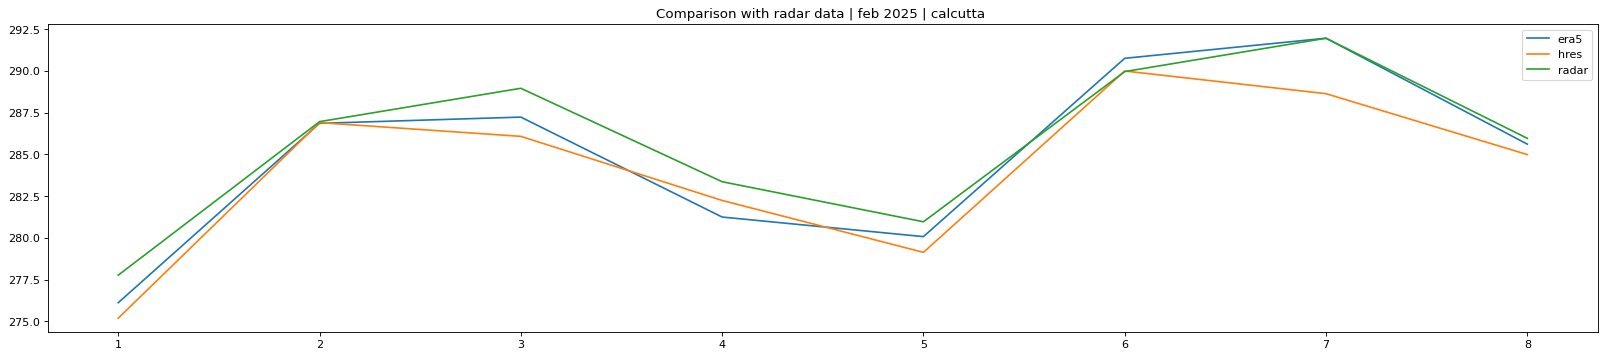

In [63]:
 # strong agreement between radar and ERA5 for Delhi, Madras, and Calcutta
# HRES is very different for all locations

t = np.arange(1,len(delhi_era5)+1)

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t,delhi_era5, color='C0', label='era5')
plt.plot(t,delhi_hres, color='C1', label='hres')
plt.plot(t,delhi_data['temp'][::6].values + 273.16, color='C2', label='radar')
plt.legend()
plt.title('Comparison with radar data | feb 2025 | calcutta ')

Text(0.5, 1.0, 'Forecast over Delhi for 1 jan 2020')

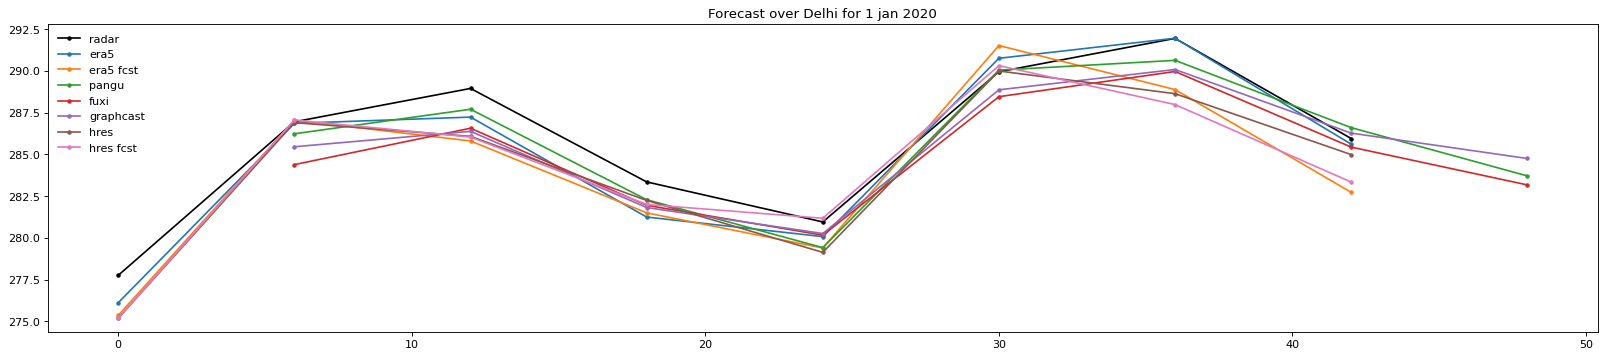

In [80]:
# comparing forecasts for one day for ERA5 and ERA5 initialized AI models - validation using RADARs

t = np.arange(0,48+6,6)
t.shape

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(221)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '.-', label='era5 fcst')

plt.plot(t[1:], delhi_pangu, '.-', label='pangu')
plt.plot(t[1:], delhi_fuxi, '.-', label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', label='graphcast')

plt.plot(t[:-1], delhi_hres, '.-', label='hres')
plt.plot(t[:-1], delhi_hres_fcst, '.-', label='hres fcst')

plt.legend(frameon=False)
plt.title('Traditional: Forecast over Delhi for 1 jan 2020')


plt.subplot(222)


plt.title('AI ERA5')

plt.subplot(223)

plt.title('AI HRES')



plt.subplot(224)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '.-', label='era5 fcst')

plt.plot(t[1:], delhi_pangu, '.-', label='pangu')
plt.plot(t[1:], delhi_fuxi, '.-', label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', label='graphcast')

plt.plot(t[:-1], delhi_hres, '.-', label='hres')
plt.plot(t[:-1], delhi_hres_fcst, '.-', label='hres fcst')

plt.title('All')
